In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [2]:
from res.plot_lib import plot_data, plot_model, set_default
import matplotlib.pyplot as plt

In [3]:
set_default()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000 # Number of samples per class
D = 1 # Number of dimensions
C = 1 # Number of classes
H = 100 # Number of hidden units

In [6]:
X = torch.unsqueeze(torch.linspace(-1,1,100),dim=1).to(device)
y = X.pow(3) + 0.3*torch.rand(X.size()).to(device)

In [7]:
print("Shapes:")
print(f"X: {tuple(X.size())}")
print(f"y: {tuple(y.size())}")

Shapes:
X: (100, 1)
y: (100, 1)


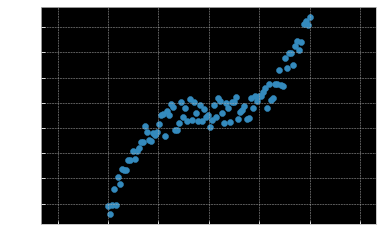

In [8]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

In [9]:
## Linear model

In [10]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [11]:
# nn package to create the linear model
# each linear module has a weight and a bias
model = nn.Sequential(
    nn.Linear(D,H),
    nn.Linear(H,C)
)
model.to(device)

# nn package also has different loss functions
# Using MSEloss for th regression task
criterion = torch.nn.MSELoss()

# optim package to apply SGD for param updates
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=lambda_l2)

# Training
for t in range(1_000):
    # feed forward to get logits
    y_pred = model(X)
    
    # compute loss
    loss = criterion(y_pred, y)
    print (f"[EPOCH]: {t}, [LOSS or MSE]: {loss.item():.6f}")
    display.clear_output(wait=True)
    
    # zero gradients before running
    # then backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # update parameters
    optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.029701


In [12]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


(-1.1, 1.1, -0.9548871725797653, 1.2026630252599717)

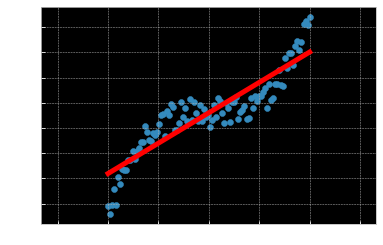

In [13]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(),y_pred.data.cpu().numpy(),'r-',lw=5)
plt.axis('equal')

In [14]:
# Two-layered network
learning_rate = 1e-3
lambda_l2 = 1e-5

In [19]:
# number of networks
n_networks = 10
models = list()
y_pretrain = list()

loss = torch.nn.MSELoss()

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D,H),
        nn.ReLU() if mod < n_networks//2 else nn.Tanh(),
        nn.Linear(H,C)
    )
    model.to(device)
    
    models.append(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
    
    # training
    for t in range(1000):
        # feed forward
        y_pred = model(X)
        
        if t == 0:
            y_pretrain.append(y_pred.detach())
            
        # compute loss and accuracy
        loss = criterion(y_pred,y)
        print (f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
    
        # zero gradient then backward pass
        optimizer.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.011594


In [20]:
print(models[0], models[-1])

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
) Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


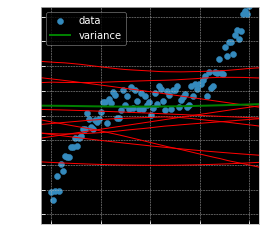

In [21]:
# Predictions before training
for y_pretrain_idx in y_pretrain:
    # new X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.unsqueeze(torch.linspace(-2,2, 100), dim=1)
    
    plt.plot(X_new.numpy(),y_pretrain_idx.cpu().numpy(),'r-',lw=1)
    
plt.scatter(X.cpu().numpy(),y.cpu().numpy(),label='data')
plt.axis('square')
plt.axis((-1.1,1.1,-1.1,1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(),y_combo.var(dim=0).cpu().numpy(),'g',label='variance');
plt.legend();

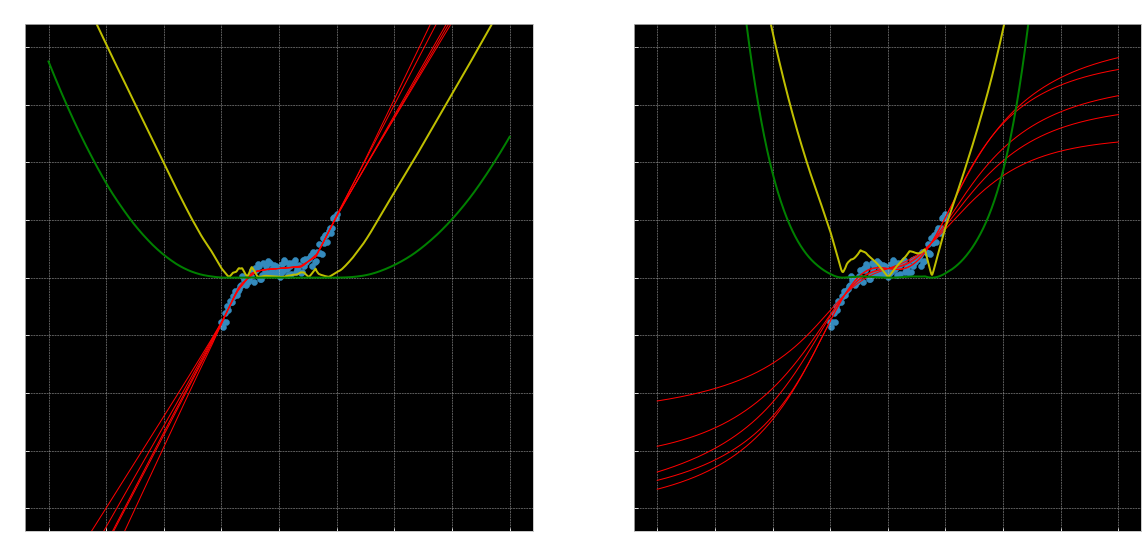

In [24]:
# Predictions after training
y_pred=list()
relu_models=models[:n_networks//2]
tanh_models=models[n_networks//2:]
plt.figure(figsize=(20,10))

def dense_prediction(models,non_linearity,zoom):
    plt.subplot(1,2,1 if non_linearity=='ReLU' else 2)
    for model in models:
        # new X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4,4,1001),dim=1).to(device)
        
        # getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))
            
        plt.plot(X_new.cpu().numpy(),y_pred[-1].cpu().numpy(),'r-',lw=1)
    plt.scatter(X.cpu().numpy(),y.cpu().numpy(),label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1,1.1,-1.1,1.1))*zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(),10*y_combo.var(dim=0).cpu().sqrt().numpy(),'y',label='10 x std')
    plt.plot(X_new.cpu().numpy(),10*y_combo.var(dim=0).cpu().numpy(),'g',label='30 x variance')
    plt.legend
    plt.title(non_linearity + 'models')
    
z=4
dense_prediction(relu_models, "ReLU", zoom = z)
dense_prediction(tanh_models, "Tanh", zoom = z)